# Setup

In [6]:
class_labels = ['Low','Intermediate','High']

In [73]:
import os
import glob
import librosa
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Feature extraction

In [11]:
##Return audio features
def feature_extraction(file_name):
    X , sample_rate = librosa.load(file_name, sr=None) #Can also load file using librosa
    if X.ndim > 1:
        X = X[:,0]
    X = X.T
            
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=20).T, axis=0) #Returns N_mel coefs
    rmse = np.mean(librosa.feature.rms(y=X).T, axis=0) #RMS Energy for each Frame (Stanford's). Returns 1 value
    spectral_flux = np.mean(librosa.onset.onset_strength(y=X, sr=sample_rate).T, axis=0) #Spectral Flux (Stanford's). Returns 1 Value
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=X).T, axis=0) #Returns 1 value

    ##Return computed audio features
    return mfccs, rmse, spectral_flux, zcr
    
# Audio parsing: Function makes call for feature extraction and returns array with features and labels 
def parse_audio_files_mfcc(parent_dir, sub_dirs, file_ext='*.mp3'): # Audio Format
    n_mfccs = 20 # This variable is tunneable with each run
    number_of_features = 3 + n_mfccs
    #number_of_features = 154 + n_mfccs # 154 are the total values returned by rest of computed features
    features, labels = np.empty((0,number_of_features)), np.empty(0)
    filenames = np.empty(0, dtype=object)
    ##Extract features for each audio file
    for label, sub_dir in enumerate(sub_dirs): ##The enumerate() function adds a counter to an iterable.
        for file_name in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)): ##parent is data, sub_dirs are the classes
            print("Actual File Name: ", file_name)
            try:
                mfccs, rmse, spectral_flux, zcr = feature_extraction(file_name)
            except Exception as e:
                print("[Error] there was an error in feature extraction. %s" % (e))
                continue
            extracted_features = np.hstack([mfccs, rmse, spectral_flux, zcr])
            features = np.vstack([features, extracted_features]) #Stack arrays in sequence vertically (row wise).
            labels = np.append(labels, label)
            filenames = np.append(filenames, file_name)
        print("Extracted features from %s, done" % (sub_dir))
    return np.array(features), np.array(labels, dtype = int), filenames ## arrays with features and corresponding labels for each

In [10]:
%ls

'Audio Feature Extraction.ipynb'*   faster-whisper/
 CNN.ipynb*                         feature_extraction_joaquin.ipynb*
'Data Exploration.ipynb'*           features/
 MLP.ipynb*                         mfcc-features-modified.npy*
 RF.ipynb*                          mfcc-filenames-modified.npy*
 RNN.ipynb*                         mfcc-labels-modified.npy*
 SVM.ipynb*                         modified-data/
 a.txt*                             test.py*
 audio-data/                        whisper.ipynb*


In [15]:
#Read audio classes directories

audio_subdirectories = os.listdir("audio-data") #Path to data folder.
audio_subdirectories.sort()
print('Audio Subdirs: ', audio_subdirectories)

Audio Subdirs:  ['001 - Low', '002 - Intermediate', '003 - High']


In [16]:
features, labels, filenames = parse_audio_files_mfcc('audio-data', audio_subdirectories) #(parent dir,sub dirs)
np.save('mfcc-features-original.npy', features)
np.save('mfcc-labels-original.npy', labels)
np.save('mfcc-filenames-original.npy', filenames)

Actual File Name:  audio-data/001 - Low/Avalinguo - Dana and Konay segment 1 - D.mp3
Actual File Name:  audio-data/001 - Low/Avalinguo - Dana and Konay segment 10 - D.mp3
Actual File Name:  audio-data/001 - Low/Avalinguo - Dana and Konay segment 102 - D.mp3
Actual File Name:  audio-data/001 - Low/Avalinguo - Dana and Konay segment 103 - D.mp3
Actual File Name:  audio-data/001 - Low/Avalinguo - Dana and Konay segment 104 - D.mp3
Actual File Name:  audio-data/001 - Low/Avalinguo - Dana and Konay segment 108 - D.mp3
Actual File Name:  audio-data/001 - Low/Avalinguo - Dana and Konay segment 11 - D.mp3
Actual File Name:  audio-data/001 - Low/Avalinguo - Dana and Konay segment 110 - D.mp3
Actual File Name:  audio-data/001 - Low/Avalinguo - Dana and Konay segment 111 - D.mp3
Actual File Name:  audio-data/001 - Low/Avalinguo - Dana and Konay segment 113 - D.mp3
Actual File Name:  audio-data/001 - Low/Avalinguo - Dana and Konay segment 114 - D.mp3
Actual File Name:  audio-data/001 - Low/Avaling

In [5]:
features, labels, filenames = parse_audio_files_mfcc('modified-data', audio_subdirectories) #(parent dir,sub dirs)
np.save('mfcc-features-modified.npy', features)
np.save('mfcc-labels-modified.npy', labels)
np.save('mfcc-filenames-modified.npy', filenames)

Actual File Name:  modified-data/001-Low/Avalinguo - Dana and Konay segment 1 - D.mp3


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Extracted features from 001-Low, done
Actual File Name:  modified-data/001-Low/Avalinguo - Dana and Konay segment 10 - D.mp3
Extracted features from 001-Low, done
Actual File Name:  modified-data/001-Low/Avalinguo - Dana and Konay segment 102 - D.mp3
Extracted features from 001-Low, done
Actual File Name:  modified-data/001-Low/Avalinguo - Dana and Konay segment 103 - D.mp3
Extracted features from 001-Low, done
Actual File Name:  modified-data/001-Low/Avalinguo - Dana and Konay segment 104 - D.mp3
Extracted features from 001-Low, done
Actual File Name:  modified-data/001-Low/Avalinguo - Dana and Konay segment 108 - D.mp3
Extracted features from 001-Low, done
Actual File Name:  modified-data/001-Low/Avalinguo - Dana and Konay segment 11 - D.mp3
Extracted features from 001-Low, done
Actual File Name:  modified-data/001-Low/Avalinguo - Dana and Konay segment 110 - D.mp3
Extracted features from 001-Low, done
Actual File Name:  modified-data/001-Low/Avalinguo - Dana and Konay segment 111 - 

In [145]:
features = np.load("yu-features-original.npy")
labels = np.load("yu-labels-original.npy")
filenames = np.load("yu-filenames-original.npy", allow_pickle=True).tolist()

In [146]:
filenames[0]

'audio-data/001 - Low/Avalinguo - Dana and Konay segment 42 - D.mp3'

In [147]:
# clean_filenames = []
# for f in filenames:
#     new_f = f[35:]
#     clean_filenames.append(new_f)
# clean = np.array(clean_filenames, dtype=object)
# clean[0]
# np.save("yu-filenames-original.npy", clean)

In [148]:
files_to_extract = ["audio-data/003 - High/Luis Suarez interview in English after being awarded November player of the month segment 1 - Woman.mp3"]
for num in [2, 3, 4, 5, 9, 14, 18, 19, 23, 26, 29]:
  files_to_extract.append(f"audio-data/003 - High/Luis Suarez interview in English after being awarded November player of the month segment {num} - W.mp3")
indices_adv_to_basic = []
for extract in files_to_extract:
    indices_adv_to_basic.append(filenames.index(extract))
print(indices_adv_to_basic)

[1147, 1195, 1192, 1191, 1194, 1188, 1141, 1140, 1196, 1193, 1189, 1190]


In [149]:
files_to_extract = ["audio-data/001 - Low/Musira  Rwandan athlete inability to fluently articulate himself in English segment 2 - Musira.mp3"]
for num in [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14]:
  files_to_extract.append(f"audio-data/001 - Low/Musira  Rwandan athlete inability to fluently articulate himself in English segment {num} - M.mp3")
indices_basic_to_intermediate = []
for extract in files_to_extract:
    indices_basic_to_intermediate.append(filenames.index(extract))
print(indices_basic_to_intermediate)

[436, 434, 430, 433, 431, 432, 435, 376, 377, 371, 370, 437]


In [150]:
files_to_extract = ["audio-data/002 - Intermediate/Elderly Chinese street cleaner speaks fluent English segment 1 - Guy.mp3"]
for num in [2, 3, 4, 13, 14, 15, 16, 17, 33, 34, 41, 42, 43, 44, 63, 75]:
  files_to_extract.append(f"audio-data/002 - Intermediate/Elderly Chinese street cleaner speaks fluent English segment {num} - G.mp3")
indices_intermediate_to_advanced = []
for extract in files_to_extract:
    indices_intermediate_to_advanced.append(filenames.index(extract))
print(indices_intermediate_to_advanced)

[962, 957, 954, 952, 958, 956, 960, 955, 959, 953, 951, 949, 948, 945, 947, 946, 950]


In [151]:
labels[962]

1

In [152]:
for ind1 in indices_adv_to_basic:
    labels[ind1] = 0
for ind2 in indices_intermediate_to_advanced:
    labels[ind2] = 2
for ind3 in indices_basic_to_intermediate:
    labels[ind3] = 1

In [153]:
labels[962]

2

In [156]:
filenames[0].split("/")[2]

'Avalinguo - Dana and Konay segment 42 - D.mp3'

In [157]:
clean_filenames = []
for f in filenames:
    new_f = f.split("/")[2]
    clean_filenames.append(new_f)
clean = np.array(clean_filenames, dtype=object)
np.save("yu-filenames-modified.npy", clean)

In [158]:
clean[0]

'Avalinguo - Dana and Konay segment 42 - D.mp3'

In [159]:
np.save('yu-features-modified.npy', features)
np.save('yu-labels-modified.npy', labels)

# Visualizing the features

In [62]:
features = np.load("yu-features-original.npy")
labels = np.load("yu-labels-original.npy")

In [63]:
features.shape

(1424, 12)

# Experiment 1

Hypothesis 1: Since the classifier isn’t learning to classify english fluency levels, but rather acting as a speaker recognition algorithm, if we label an advanced speaker’s audio fragments as “Basic”, or an intermediate speaker’s audio as “Advanced” and so forth, the classifier’s performance shouldn’t be affected.
Create a new dataset by moving 12 audio fragments from “Basic” to “Intermediate”, 17 from “Intermediate” to “Advanced”, and 12 from “Advanced” to “Basic”.
Train the model with the highest accuracy from [1] (SVM) with the original dataset, maintaining as many unchanged parameters as possible.
Find accuracy and confusion matrix to use as reference.
Train the model with the highest accuracy from [1] (SVM) with the modified dataset, maintaining as many unchanged parameters as possible.
Find accuracy and confusion matrix.
Compare the results.


## Original dataset/MFCC/SVM

In [72]:
X = np.load('mfcc-features-original.npy') # list of features
y = np.load('mfcc-labels-original.npy').ravel() # labels are the target

# Fix random seed number
np.random.seed(7)

# Load the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

# SVM classifier
svm_clf = SVC(C=200, gamma = 0.0001, kernel='rbf', decision_function_shape="ovr")
#svm_clf = LinearSVC(random_state=42) # HandsOn git

# Fit model
svm_clf.fit(X_train, y_train) #From Beif github

NameError: name 'SVC' is not defined

### Accuracy

In [30]:
# Predictions
y_predict = svm_clf.predict(X_test)
# Accuracy Result
acc = svm_clf.score(X_test, y_test)
# Accuracy Result
print("Final accuracy = %0.4f" %acc)

Final accuracy = 0.9369


### Confusion matrix

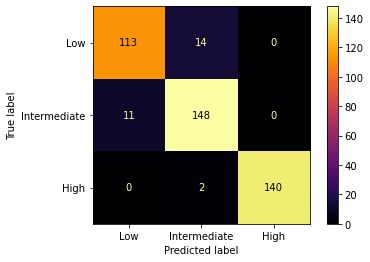

In [31]:
cm = confusion_matrix(y_test, y_predict)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
cm_display.plot(cmap="inferno")

## Original dataset/MFCC/MLP

In [74]:
# Fix random seed number
np.random.seed(7)

# Load the data
X = np.load('mfcc-features-original.npy')
y = np.load('mfcc-labels-original.npy').ravel()  #Return a contiguous flattened array.

number_of_features = len(X[1])  #This is variable with each run
number_of_classes = 3

# Sample data randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)  #70% Train, 30% Test

# Neural Network Architecture
model = Sequential()  # Define Sequential model

# Using relu on the first two layers and softmax on the output layer

# 1st Layer
#N neurons, Number_Fatures-dimensional vectors
model.add(Dense(128, input_dim=number_of_features, activation='relu'))  #32, 64, 128, 256, 512, 1024
model.add(Dropout(0.5))

# 2nd Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# 3rd Layer. Output 3 neurons corresponding the number of classes
# The sigmoid function is used for the two-class logistic regression,
# whereas the softmax function is used for the multiclass logistic regression
model.add(Dense(number_of_classes, activation='softmax'))

# Model Compilation. Loss for multi-class classification problem
# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# rmsprop = 'rmsprop'
adam = 'adam'
model.compile(loss='categorical_crossentropy',
              optimizer=adam,  #rmsprop better than sgd
              metrics=['accuracy'])

# Convert labels to categorical one-hot encoding
y_train = to_categorical(y_train - 1, num_classes=number_of_classes)  # Convert class vector into binary Matrix
y_test = to_categorical(y_test - 1, num_classes=number_of_classes)

# Train and test
history = model.fit(X_train, y_train, epochs=100, batch_size=64)  #batch 32, 64, 128, 256, 512

Epoch 1/100
16/16 [==============================] - 3s 17ms/step - loss: 43.0219 - accuracy: 0.3484
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 29.7588 - accuracy: 0.3815
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 20.6308 - accuracy: 0.3645
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 15.2823 - accuracy: 0.3865
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 11.3975 - accuracy: 0.3916
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 8.3171 - accuracy: 0.4227
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 6.6401 - accuracy: 0.4448
Epoch 8/100
16/16 [==============================] - 0s 8ms/step - loss: 5.1535 - accuracy: 0.4618
Epoch 9/100
16/16 [==============================] - 0s 13ms/step - loss: 4.2906 - accuracy: 0.4839
Epoch 10/100
16/16 [==============================] - 0s 9ms/step - loss: 3.8365 - accuracy: 0.4428


In [75]:
model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 128)               3072      
                                                                 
 dropout_80 (Dropout)        (None, 128)               0         
                                                                 
 dense_121 (Dense)           (None, 128)               16512     
                                                                 
 dropout_81 (Dropout)        (None, 128)               0         
                                                                 
 dense_122 (Dense)           (None, 3)                 387       
                                                                 
Total params: 19971 (78.01 KB)
Trainable params: 19971 (78.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


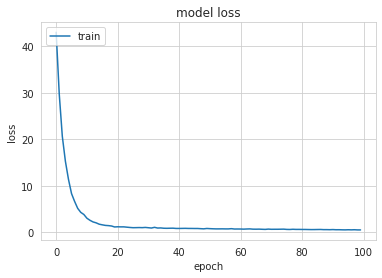

In [76]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## Accuracy

In [77]:
score, acc = model.evaluate(X_test, y_test, batch_size=64)
print('Test score:', score)
print('Test accuracy:', acc)

7/7 [==============================] - 0s 7ms/step - loss: 0.4226 - accuracy: 0.8294
Test score: 0.4225864112377167
Test accuracy: 0.8294392228126526


In [78]:
Y_pred = model.predict(X_test)

14/14 [==============================] - 0s 2ms/step


## Confusion matrix

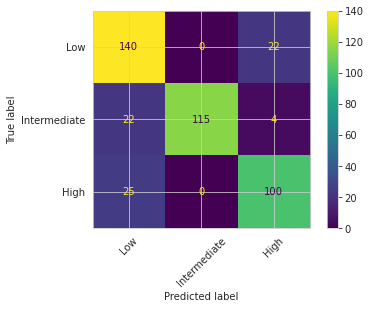

In [79]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_predict_non_category = [ np.argmax(t) for t in Y_pred ]
y_test_non_category = [ np.argmax(t) for t in y_test ]
cm = confusion_matrix(y_test_non_category, y_predict_non_category)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
cm_display.plot(xticks_rotation=45)

## Original dataset/Yu embeddings/SVM

In [181]:
X = np.load('yu-features-original.npy')  # list of features
y = np.load('yu-labels-original.npy').ravel()  # labels are the target

# Fix random seed number
np.random.seed(7)

# Load the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

# SVM classifier
svm_clf = SVC(C=200, gamma=0.0001, kernel='rbf', decision_function_shape="ovr")
#svm_clf = LinearSVC(random_state=42) # HandsOn git

# Fit model
svm_clf.fit(X_train, y_train)  #From Beif github


SVC(C=200, gamma=0.0001)

In [182]:
### Accuracy
# Predictions
y_predict = svm_clf.predict(X_test)
# Accuracy Result
acc = svm_clf.score(X_test, y_test)
# Accuracy Result
print("Final accuracy = %0.4f" % acc)


Final accuracy = 0.5327


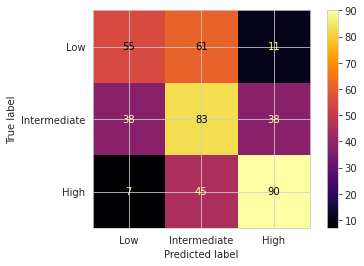

In [183]:
### Confusion matrix
cm = confusion_matrix(y_test, y_predict)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
cm_display.plot(cmap="inferno")

## Original dataset/Yu embeddings/MLP

In [42]:
# Fix random seed number
np.random.seed(7)

# Load the data
X = np.load('yu-features-original.npy')
y = np.load('yu-labels-original.npy').ravel()  #Return a contiguous flattened array.

number_of_features = len(X[1])  #This is variable with each run
number_of_classes = 3

# Sample data randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)  #70% Train, 30% Test

# Neural Network Architecture
model = Sequential()  # Define Sequential model

# Using relu on the first two layers and softmax on the output layer

# 1st Layer
#N neurons, Number_Fatures-dimensional vectors
model.add(Dense(128, input_dim=number_of_features, activation='relu'))  #32, 64, 128, 256, 512, 1024
model.add(Dropout(0.5))

# 2nd Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# 3rd Layer. Output 3 neurons corresponding the number of classes
# The sigmoid function is used for the two-class logistic regression,
# whereas the softmax function is used for the multiclass logistic regression
model.add(Dense(number_of_classes, activation='softmax'))

# Model Compilation. Loss for multi-class classification problem
# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# rmsprop = 'rmsprop'
adam = 'adam'
model.compile(loss='categorical_crossentropy',
              optimizer=adam,  #rmsprop better than sgd
              metrics=['accuracy'])

# Convert labels to categorical one-hot encoding
y_train = to_categorical(y_train - 1, num_classes=number_of_classes)  # Convert class vector into binary Matrix
y_test = to_categorical(y_test - 1, num_classes=number_of_classes)

# Train and test
history = model.fit(X_train, y_train, epochs=100, batch_size=64)  #batch 32, 64, 128, 256, 512


Epoch 1/100
16/16 [==============================] - 2s 9ms/step - loss: 1.2428 - accuracy: 0.3624
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 1.1396 - accuracy: 0.4347
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 1.1023 - accuracy: 0.4749
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 1.0323 - accuracy: 0.4719
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 1.0049 - accuracy: 0.5010
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.9739 - accuracy: 0.5361
Epoch 7/100
16/16 [==============================] - 0s 7ms/step - loss: 0.9540 - accuracy: 0.5512
Epoch 8/100
16/16 [==============================] - 0s 7ms/step - loss: 0.9446 - accuracy: 0.5492
Epoch 9/100
16/16 [==============================] - 0s 7ms/step - loss: 0.9530 - accuracy: 0.5422
Epoch 10/100
16/16 [==============================] - 0s 7ms/step - loss: 0.9097 - accuracy: 0.5733
Epoch 11

In [43]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               1664      
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 128)               16512     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 3)                 387       
                                                                 
Total params: 18563 (72.51 KB)
Trainable params: 18563 (72.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


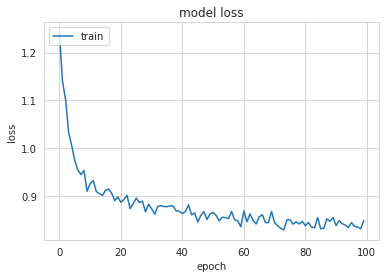

In [44]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## Accuracy

In [45]:
score, acc = model.evaluate(X_test, y_test, batch_size=64)
print('Test score:', score)
print('Test accuracy:', acc)

7/7 [==============================] - 0s 7ms/step - loss: 0.8862 - accuracy: 0.5607
Test score: 0.8862173557281494
Test accuracy: 0.5607476830482483


In [46]:
Y_pred = model.predict(X_test)

14/14 [==============================] - 0s 3ms/step


## Confusion matrix

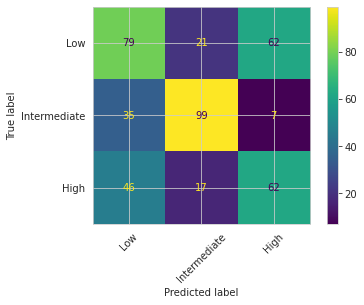

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_predict_non_category = [ np.argmax(t) for t in Y_pred ]
y_test_non_category = [ np.argmax(t) for t in y_test ]
cm = confusion_matrix(y_test_non_category, y_predict_non_category)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
cm_display.plot(xticks_rotation=45)

## Modified dataset/MFCC/SVM

In [80]:
X = np.load('mfcc-features-modified.npy') # list of features
y = np.load('mfcc-labels-modified.npy').ravel() # labels are the target

# Fix random seed number
np.random.seed(7)

# Load the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

# SVM classifier
svm_clf = SVC(C=200, gamma = 0.0001, kernel='rbf', decision_function_shape="ovr")
#svm_clf = LinearSVC(random_state=42) # HandsOn git

# Fit model
svm_clf.fit(X_train, y_train) #From Beif github

SVC(C=200, gamma=0.0001)

### Find accuracy

In [81]:
# Predictions
y_predict = svm_clf.predict(X_test)
# Accuracy Result
acc = svm_clf.score(X_test, y_test)
# Accuracy Result
print("Final accuracy = %0.4f" %acc)

Final accuracy = 0.9299


### Confusion matrix

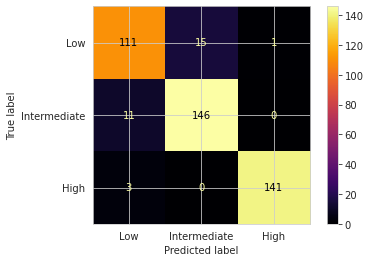

In [82]:
cm = confusion_matrix(y_test, y_predict)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
cm_display.plot(cmap="inferno")

## Modified dataset/MFCC/MLP

In [86]:
# Fix random seed number
np.random.seed(7)

# Load the data
X = np.load('mfcc-features-modified.npy')
y = np.load('mfcc-labels-modified.npy').ravel()  #Return a contiguous flattened array.

number_of_features = len(X[1])  #This is variable with each run
number_of_classes = 3

# Sample data randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)  #70% Train, 30% Test

# Neural Network Architecture
model = Sequential()  # Define Sequential model

# Using relu on the first two layers and softmax on the output layer

# 1st Layer
#N neurons, Number_Fatures-dimensional vectors
model.add(Dense(128, input_dim=number_of_features, activation='relu'))  #32, 64, 128, 256, 512, 1024
model.add(Dropout(0.5))

# 2nd Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# 3rd Layer. Output 3 neurons corresponding the number of classes
# The sigmoid function is used for the two-class logistic regression,
# whereas the softmax function is used for the multiclass logistic regression
model.add(Dense(number_of_classes, activation='softmax'))

# Model Compilation. Loss for multi-class classification problem
# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# rmsprop = 'rmsprop'
adam = 'adam'
model.compile(loss='categorical_crossentropy',
              optimizer=adam,  #rmsprop better than sgd
              metrics=['accuracy'])

# Convert labels to categorical one-hot encoding
y_train = to_categorical(y_train - 1, num_classes=number_of_classes)  # Convert class vector into binary Matrix
y_test = to_categorical(y_test - 1, num_classes=number_of_classes)

# Train and test
history = model.fit(X_train, y_train, epochs=100, batch_size=64)  #batch 32, 64, 128, 256, 512

Epoch 1/100
16/16 [==============================] - 3s 17ms/step - loss: 33.2455 - accuracy: 0.3434
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 21.3350 - accuracy: 0.3785
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 15.0576 - accuracy: 0.3795
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 10.4661 - accuracy: 0.4588
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 8.0222 - accuracy: 0.4578
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 6.0309 - accuracy: 0.4719
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 4.8941 - accuracy: 0.4849
Epoch 8/100
16/16 [==============================] - 0s 13ms/step - loss: 4.1631 - accuracy: 0.5030
Epoch 9/100
16/16 [==============================] - 0s 8ms/step - loss: 3.3027 - accuracy: 0.4920
Epoch 10/100
16/16 [==============================] - 0s 8ms/step - loss: 2.7980 - accuracy: 0.5000
Ep

In [87]:
model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_123 (Dense)           (None, 128)               3072      
                                                                 
 dropout_82 (Dropout)        (None, 128)               0         
                                                                 
 dense_124 (Dense)           (None, 128)               16512     
                                                                 
 dropout_83 (Dropout)        (None, 128)               0         
                                                                 
 dense_125 (Dense)           (None, 3)                 387       
                                                                 
Total params: 19971 (78.01 KB)
Trainable params: 19971 (78.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


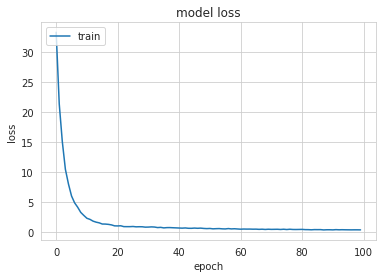

In [88]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## Accuracy

In [89]:
score, acc = model.evaluate(X_test, y_test, batch_size=64)
print('Test score:', score)
print('Test accuracy:', acc)

7/7 [==============================] - 0s 7ms/step - loss: 0.3886 - accuracy: 0.8224
Test score: 0.388628214597702
Test accuracy: 0.822429895401001


In [90]:
Y_pred = model.predict(X_test)

14/14 [==============================] - 0s 3ms/step


## Confusion matrix

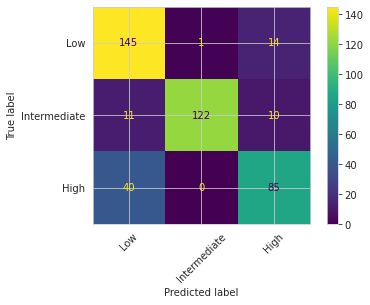

In [91]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_predict_non_category = [ np.argmax(t) for t in Y_pred ]
y_test_non_category = [ np.argmax(t) for t in y_test ]
cm = confusion_matrix(y_test_non_category, y_predict_non_category)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
cm_display.plot(xticks_rotation=45)

## Modified dataset/Yu features/SVM

In [83]:
X = np.load('yu-features-modified.npy')  # list of features
y = np.load('yu-labels-modified.npy').ravel()  # labels are the target

# Fix random seed number
np.random.seed(7)

# Load the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

# SVM classifier
svm_clf = SVC(C=200, gamma=0.0001, kernel='rbf', decision_function_shape="ovr")
#svm_clf = LinearSVC(random_state=42) # HandsOn git

# Fit model
svm_clf.fit(X_train, y_train)  #From Beif github


SVC(C=200, gamma=0.0001)

In [84]:
### Accuracy
# Predictions
y_predict = svm_clf.predict(X_test)
# Accuracy Result
acc = svm_clf.score(X_test, y_test)
# Accuracy Result
print("Final accuracy = %0.4f" % acc)


Final accuracy = 0.5537


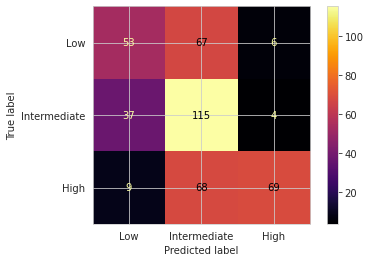

In [85]:
### Confusion matrix
cm = confusion_matrix(y_test, y_predict)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
cm_display.plot(cmap="inferno")

## Experiment 2

## MFCCs/SVM

In [108]:
names = np.load("mfcc-filenames-modified.npy", allow_pickle=True).tolist()

Find audios to be extracted.

In [109]:
files_to_extract = ["modified-data/001-Low/Luis Suarez interview in English after being awarded November player of the month segment 1 - Woman.mp3"]
for num in [2, 3, 4, 5, 9, 14, 18, 19, 23, 26, 29]:
  files_to_extract.append(f"modified-data/001-Low/Luis Suarez interview in English after being awarded November player of the month segment {num} - W.mp3")
indices = []
for extract in files_to_extract:
    indices.append(names.index(extract))
print(indices)

[426, 430, 434, 435, 436, 437, 427, 428, 429, 431, 432, 433]


In [110]:
X = np.load('mfcc-features-modified.npy')  # list of features
y = np.load('mfcc-labels-modified.npy').ravel()  # labels are the target

In [111]:
xx = 0
for ind in indices:
    print(files_to_extract[xx], class_labels[y[ind]])
    xx += 1
    vals = []
    valsout = []
    arr = X
    arrout = y
    for i in range(arr.shape[0]):
        if i != ind:
            vals.append(arr[i])
            valsout.append(arrout[i])
    newX = np.array(vals)
    print(newX.shape)
    newY = np.array(valsout)
    print(newY.shape)

    # Fix random seed number
    np.random.seed(7)

    # Load the data
    # X_train, X_test, y_train, y_test = train_test_split(newX, newY, test_size=0.3, random_state=30)

    # SVM classifier
    svm_clf = SVC(C=200, gamma = 0.0001, kernel='rbf', decision_function_shape="ovr")

    # Fit model
    svm_clf.fit(newX, newY)

    pred_arr = svm_clf.predict(X[ind].reshape(1, -1))
    print("Pred: ", class_labels[pred_arr[0]])

modified-data/001-Low/Luis Suarez interview in English after being awarded November player of the month segment 1 - Woman.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
modified-data/001-Low/Luis Suarez interview in English after being awarded November player of the month segment 2 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Intermediate
modified-data/001-Low/Luis Suarez interview in English after being awarded November player of the month segment 3 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
modified-data/001-Low/Luis Suarez interview in English after being awarded November player of the month segment 4 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
modified-data/001-Low/Luis Suarez interview in English after being awarded November player of the month segment 5 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Intermediate
modified-data/001-Low/Luis Suarez interview in English after being awarded November player of the month segment 9 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
modified-data/001-Low/Luis Suarez intervie

## MFCCs/MLP

In [97]:
X = np.load('mfcc-features-modified.npy')  # list of features
y = np.load('mfcc-labels-modified.npy').ravel()  # labels are the target
number_of_features = len(X[1])  #This is variable with each run
number_of_classes = 3
xx = 0
for ind in indices:
    print(files_to_extract[xx], class_labels[y[ind]])
    xx += 1
    vals = []
    valsout = []
    arr = X
    arrout = y
    for i in range(arr.shape[0]):
        if i != ind:
            vals.append(arr[i])
            valsout.append(arrout[i])
    newX = np.array(vals)
    print(newX.shape)
    newY = np.array(valsout)
    print(newY.shape)

    # Fix random seed number
    np.random.seed(7)

    # Neural Network Architecture
    model = Sequential()  # Define Sequential model

    # Using relu on the first two layers and softmax on the output layer

    # 1st Layer
    #N neurons, Number_Fatures-dimensional vectors
    model.add(Dense(128, input_dim=number_of_features, activation='relu'))  #32, 64, 128, 256, 512, 1024
    model.add(Dropout(0.5))

    # 2nd Layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # 3rd Layer. Output 3 neurons corresponding the number of classes
    # The sigmoid function is used for the two-class logistic regression,
    # whereas the softmax function is used for the multiclass logistic regression
    model.add(Dense(number_of_classes, activation='softmax'))

    # Model Compilation. Loss for multi-class classification problem
    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    # rmsprop = 'rmsprop'
    adam = 'adam'
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,  #rmsprop better than sgd
                  metrics=['accuracy'])

    # Convert labels to categorical one-hot encoding
    newY = to_categorical(newY - 1, num_classes=number_of_classes)  # Convert class vector into binary Matrix

    # Train and test
    model.fit(newX, newY, epochs=100, batch_size=64, verbose=0)  #batch 32, 64, 128, 256, 512

    pred_arr = model(X[ind].reshape(1, -1))
    print("Pred: ", class_labels[np.argmax(pred_arr, 1)[0]])

modified-data/001-Low/Luis Suarez interview in English after being awarded November player of the month segment 1 - Woman.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
modified-data/001-Low/Luis Suarez interview in English after being awarded November player of the month segment 2 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
modified-data/001-Low/Luis Suarez interview in English after being awarded November player of the month segment 3 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
modified-data/001-Low/Luis Suarez interview in English after being awarded November player of the month segment 4 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
modified-data/001-Low/Luis Suarez interview in English after being awarded November player of the month segment 5 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
modified-data/001-Low/Luis Suarez interview in English after being awarded November player of the month segment 9 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
modified-data/001-Low/Luis Suarez interview in English after

KeyboardInterrupt: 

## Yu features/SVM

In [112]:
names = np.load("yu-filenames-modified.npy", allow_pickle=True).tolist()

In [113]:
files_to_extract = [
    "Luis Suarez interview in English after being awarded November player of the month segment 1 - Woman.mp3"]
for num in [2, 3, 4, 5, 9, 14, 18, 19, 23, 26, 29]:
    files_to_extract.append(
        f"Luis Suarez interview in English after being awarded November player of the month segment {num} - W.mp3")
indices = []
for extract in files_to_extract:
    indices.append(names.index(extract))
print(indices)

[1147, 1195, 1192, 1191, 1194, 1188, 1141, 1140, 1196, 1193, 1189, 1190]


In [114]:
X = np.load('yu-features-modified.npy')  # list of features
y = np.load('yu-labels-modified.npy').ravel()  # labels are the target
xx = 0
for ind in indices:
    print(files_to_extract[xx], class_labels[y[ind]])
    xx += 1
    vals = []
    valsout = []
    arr = X
    arrout = y
    for i in range(arr.shape[0]):
        if i != ind:
            vals.append(arr[i])
            valsout.append(arrout[i])
    newX = np.array(vals)
    print(newX.shape)
    newY = np.array(valsout)
    print(newY.shape)

    # Fix random seed number
    np.random.seed(7)

    # Load the data
    # X_train, X_test, y_train, y_test = train_test_split(newX, newY, test_size=0.3, random_state=30)

    # SVM classifier
    svm_clf = SVC(C=200, gamma=0.0001, kernel='rbf', decision_function_shape="ovr")

    # Fit model
    svm_clf.fit(newX, newY)

    pred_arr = svm_clf.predict(X[ind].reshape(1, -1))
    print("Pred: ", class_labels[pred_arr[0]])

Luis Suarez interview in English after being awarded November player of the month segment 1 - Woman.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November player of the month segment 2 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November player of the month segment 3 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November player of the month segment 4 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November player of the month segment 5 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November player of the month segment 9 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November player of the month segment 14 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  Interme

## Yu features/MLP

In [116]:
X = np.load('yu-features-modified.npy')  # list of features
y = np.load('yu-labels-modified.npy').ravel()  # labels are the target
number_of_features = len(X[1])  #This is variable with each run
number_of_classes = 3
xx = 0
for ind in indices:
    print(files_to_extract[xx], class_labels[y[ind]])
    xx += 1
    vals = []
    valsout = []
    arr = X
    arrout = y
    for i in range(arr.shape[0]):
        if i != ind:
            vals.append(arr[i])
            valsout.append(arrout[i])
    newX = np.array(vals)
    print(newX.shape)
    newY = np.array(valsout)
    print(newY.shape)

    # Fix random seed number
    np.random.seed(7)

    # Neural Network Architecture
    model = Sequential()  # Define Sequential model

    # Using relu on the first two layers and softmax on the output layer

    # 1st Layer
    #N neurons, Number_Fatures-dimensional vectors
    model.add(Dense(128, input_dim=number_of_features, activation='relu'))  #32, 64, 128, 256, 512, 1024
    model.add(Dropout(0.5))

    # 2nd Layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # 3rd Layer. Output 3 neurons corresponding the number of classes
    # The sigmoid function is used for the two-class logistic regression,
    # whereas the softmax function is used for the multiclass logistic regression
    model.add(Dense(number_of_classes, activation='softmax'))

    # Model Compilation. Loss for multi-class classification problem
    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    # rmsprop = 'rmsprop'
    adam = 'adam'
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,  #rmsprop better than sgd
                  metrics=['accuracy'])

    # Convert labels to categorical one-hot encoding
    newY = to_categorical(newY - 1, num_classes=number_of_classes)  # Convert class vector into binary Matrix

    # Train and test
    model.fit(newX, newY, epochs=100, batch_size=64, verbose=0)  #batch 32, 64, 128, 256, 512

    pred_arr = model(X[ind].reshape(1, -1))
    print("Pred: ", class_labels[np.argmax(pred_arr, 1)[0]])

Luis Suarez interview in English after being awarded November player of the month segment 1 - Woman.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November player of the month segment 2 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November player of the month segment 3 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November player of the month segment 4 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November player of the month segment 5 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November player of the month segment 9 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
Luis Suarez interview in English after being awarded November player of the month segment 14 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  Interme